In [28]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from pandas.api.types import CategoricalDtype

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, ElasticNet 
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 150)

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
finaldf = pd.read_csv('/Users/Julia/Documents/bootcamp/DC_capstone/finaldf.csv', low_memory=False)
finaldf.head()

PRICE            SALE_DATE  SALE_NUM QUALIFIED QUADRANT    WARD  \
0  1095000.0  2003-11-25 00:00:00       1.0         Q       NW  Ward 2   
1  2100000.0  2016-06-21 00:00:00       3.0         Q       NW  Ward 2   
2  1602000.0  2006-07-12 00:00:00       1.0         Q       NW  Ward 2   
3  1950000.0  2010-02-26 00:00:00       1.0         Q       NW  Ward 2   
4  1050000.0  2011-09-29 00:00:00       1.0         Q       NW  Ward 2   

   SQUARE        NBHD           SUBNBHD  CENSUS_TRACT CENSUS_BLOCK  ZIPCODE  \
0     152  Old City 2  040 D Old City 2          4201  004201 2006  20009.0   
1     152  Old City 2  040 D Old City 2          4201  004201 2006  20009.0   
2     152  Old City 2  040 D Old City 2          4201  004201 2006  20009.0   
3     152  Old City 2  040 D Old City 2          4201  004201 2006  20009.0   
4     152  Old City 2  040 D Old City 2          4201  004201 2005  20009.0   

    LATITUDE  LONGITUDE    STYLE      STRUCT  USECODE  UNITS  STORIES  \
0  38.914680 -77.040832  3 Story  Row Inside     24.0    2.0      3.0   
1  38.914684 -77.040678  3 Story  Row Inside     24.0    2.0      3.0   
2  38.914683 -77.040629  3 Story  Row Inside     24.0    2.0      3.0   
3  38.914331 -77.039715  4 Story  Row Inside     11.0    1.0      4.0   
4  38.915408 -77.040129  3 Story  Row Inside     24.0    2.0      3.0   

       GRADE      CNDTN  LANDAREA     GBA  GBA_LIVING  YR_ORIGIN  YR_EXT  \
0  Very Good       Good    1680.0  2522.0       700.0     1910.0  1972.0   
1  Very Good  Very Good    1680.0  2522.0       700.0     1910.0  1984.0   
2  Very Good       Good    1680.0  2484.0       700.0     1900.0  1984.0   
3  Very Good       Good    2196.0  5344.0       700.0     1913.0  1972.0   
4  Very Good    Average    1627.0  2401.0       700.0     1906.0  1972.0   

   YR_RMDL  ROOMS  BEDRMS  BATHRMS  KITCHENS           HEAT AC  FIREPLACES  \
0   1988.0    8.0     4.0      4.0       2.0      Warm Cool  Y         5.0   
1   2009.0    9.0     5.0      3.5       2.0  Hot Water Rad  Y         4.0   
2   2003.0    8.0     5.0      3.5       2.0  Hot Water Rad  Y         3.0   
3   2007.0   10.0     5.0      4.0       1.0  Hot Water Rad  Y         4.0   
4   2011.0    8.0     4.0      3.5       2.0  Hot Water Rad  Y         1.0   

         ROOF   INTWALL       EXTWALL  
0  Metal- Sms  Hardwood  Common Brick  
1    Built Up  Hardwood  Common Brick  
2    Built Up  Hardwood  Common Brick  
3    Built Up  Hardwood  Common Brick  
4  Metal- Sms  Hardwood  Common Brick

In [4]:
# MODIFICATIONS

#new dataframe with timestamp instead of datetime for SALE_DATE
finaldf.SALE_DATE = pd.to_datetime(finaldf.SALE_DATE)

times = []
for i in finaldf['SALE_DATE']:
    times.append(datetime.timestamp(i))
finaldf['SALE_DATE'] = times
    
#dropping LATITUDE and LONGITUDE because these values zig-zag between properties.
#dropping CENSUS_TRACT because it's included in CENSUS_BLOCK.
dropdf = finaldf.drop(['LATITUDE', 'LONGITUDE', 'CENSUS_TRACT'], axis=1)

#remove spaces
strips=dropdf['CENSUS_BLOCK'].apply(str).str.replace(" ", "")
dropdf['CENSUS_BLOCK'] = strips

#change numerical to categorical
for col in ['SALE_NUM', 'SQUARE', 'CENSUS_BLOCK', 'USECODE', 'ZIPCODE']:
    dropdf[col] = dropdf[col].astype('category')


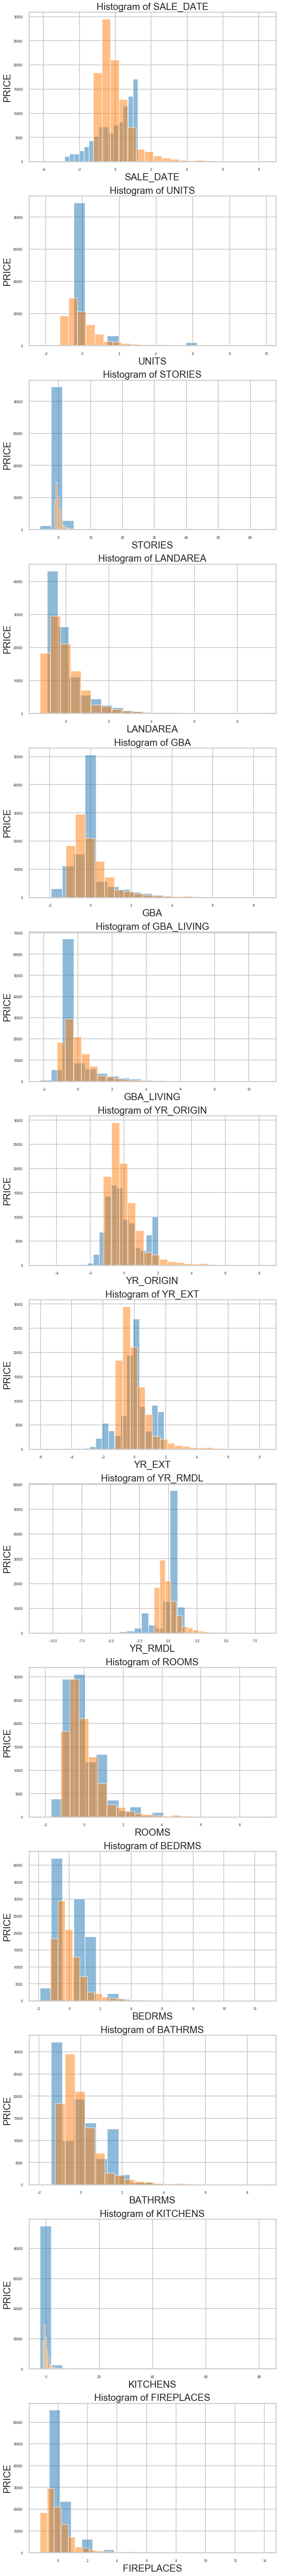

In [4]:
# CHECKING DISTRIBUTIONS

# it does not appear that the variables would benefit from transformations.

def hist_all(df, target):
    #scaling numerical cols
    num_list = list(df.loc[:, (df.dtypes == np.float64)].columns)
    scaledf = pd.DataFrame()
    for col in num_list:
        scaledf[col] = (df[col] - np.mean(df[col])) / np.std(df[col])
    num_list.remove(target)
    
    #histograms for numerical facets
    fig, axs = plt.subplots(len(scaledf.columns)-3,1, figsize=(10,6*len(scaledf.columns)))
    plt.rc('xtick', labelsize='small') 
    plt.rc('ytick', labelsize='small') 
    for i, name in enumerate(num_list):
        if (str(name) != target):
            plt.subplot(len(num_list), 1, i+1)
            a = plt.hist(scaledf[name], alpha=.5, bins=20)
            a = plt.hist(scaledf[target], alpha=.5, bins=20)
            plt.xlabel(name)
            plt.ylabel(target)
            plt.title("Histogram of %s" % name)  
    plt.tight_layout()

hist_all(dropdf, 'PRICE')

In [ ]:
# CORRELATION MATRIX

num_df = dropdf.loc[:, (dropdf.dtypes == np.float64)]
num_df.drop('PRICE', axis=1)
num_df.corr()

PRICE  SALE_DATE     UNITS   STORIES  LANDAREA       GBA  \
PRICE       1.000000   0.340855  0.039034  0.194127  0.285163  0.495503   
SALE_DATE   0.340855   1.000000 -0.043928  0.000099 -0.117953 -0.030799   
UNITS       0.039034  -0.043928  1.000000  0.136183  0.075532  0.328363   
STORIES     0.194127   0.000099  0.136183  1.000000 -0.098306  0.285626   
LANDAREA    0.285163  -0.117953  0.075532 -0.098306  1.000000  0.423964   
GBA         0.495503  -0.030799  0.328363  0.285626  0.423964  1.000000   
GBA_LIVING  0.209558   0.070168 -0.075004 -0.033762 -0.125509 -0.017845   
YR_ORIGIN  -0.052633   0.091015 -0.146008 -0.025822 -0.102294  0.005036   
YR_EXT      0.224067   0.090148 -0.017365  0.117069  0.118530  0.134347   
YR_RMDL     0.131332   0.181134  0.028958  0.000285  0.131647 -0.011136   
ROOMS       0.341580  -0.088136  0.515133  0.188263  0.561875  0.487799   
BEDRMS      0.368075  -0.055117  0.365530  0.176294  0.570182  0.432428   
BATHRMS     0.544734   0.051947  0.361999  0.226098  0.498593  0.582730   
KITCHENS    0.071272  -0.027365  0.917370  0.132691  0.089457  0.327427   
FIREPLACES  0.457010  -0.075685  0.032110  0.160580  0.417155  0.430722   

            GBA_LIVING  YR_ORIGIN    YR_EXT   YR_RMDL     ROOMS    BEDRMS  \
PRICE         0.209558  -0.052633  0.224067  0.131332  0.341580  0.368075   
SALE_DATE     0.070168   0.091015  0.090148  0.181134 -0.088136 -0.055117   
UNITS        -0.075004  -0.146008 -0.017365  0.028958  0.515133  0.365530   
STORIES      -0.033762  -0.025822  0.117069  0.000285  0.188263  0.176294   
LANDAREA     -0.125509  -0.102294  0.118530  0.131647  0.561875  0.570182   
GBA          -0.017845   0.005036  0.134347 -0.011136  0.487799  0.432428   
GBA_LIVING    1.000000   0.191063  0.030041  0.035651 -0.048596  0.006832   
YR_ORIGIN     0.191063   1.000000  0.687240  0.123334 -0.225343 -0.247055   
YR_EXT        0.030041   0.687240  1.000000  0.293536  0.159569  0.167422   
YR_RMDL       0.035651   0.123334  0.293536  1.000000  0.186536  0.233489   
ROOMS        -0.048596  -0.225343  0.159569  0.186536  1.000000  0.845456   
BEDRMS        0.006832  -0.247055  0.167422  0.233489  0.845456  1.000000   
BATHRMS       0.098684  -0.074426  0.275745  0.219189  0.729032  0.735934   
KITCHENS     -0.079702  -0.154518 -0.005713  0.040200  0.514500  0.379513   
FIREPLACES   -0.024699  -0.197663  0.067424 -0.023505  0.364724  0.368904   

             BATHRMS  KITCHENS  FIREPLACES  
PRICE       0.544734  0.071272    0.457010  
SALE_DATE   0.051947 -0.027365   -0.075685  
UNITS       0.361999  0.917370    0.032110  
STORIES     0.226098  0.132691    0.160580  
LANDAREA    0.498593  0.089457    0.417155  
GBA         0.582730  0.327427    0.430722  
GBA_LIVING  0.098684 -0.079702   -0.024699  
YR_ORIGIN  -0.074426 -0.154518   -0.197663  
YR_EXT      0.275745 -0.005713    0.067424  
YR_RMDL     0.219189  0.040200   -0.023505  
ROOMS       0.729032  0.514500    0.364724  
BEDRMS      0.735934  0.379513    0.368904  
BATHRMS     1.000000  0.380130    0.438542  
KITCHENS    0.380130  1.000000    0.054315  
FIREPLACES  0.438542  0.054315    1.000000

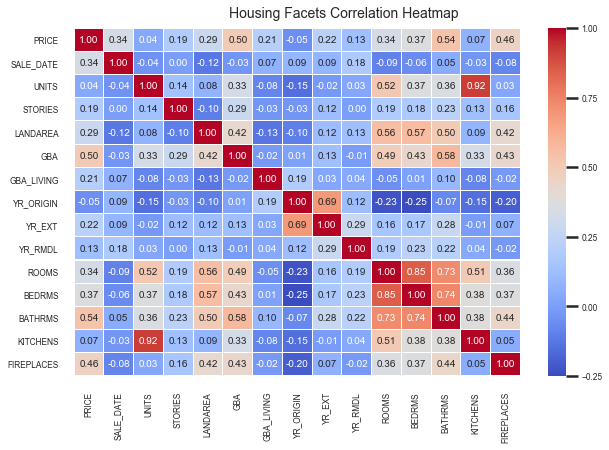

In [ ]:
# HEATMAP

f, ax = plt.subplots(figsize=(10, 6))
corr = num_df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Housing Facets Correlation Heatmap', fontsize=14)

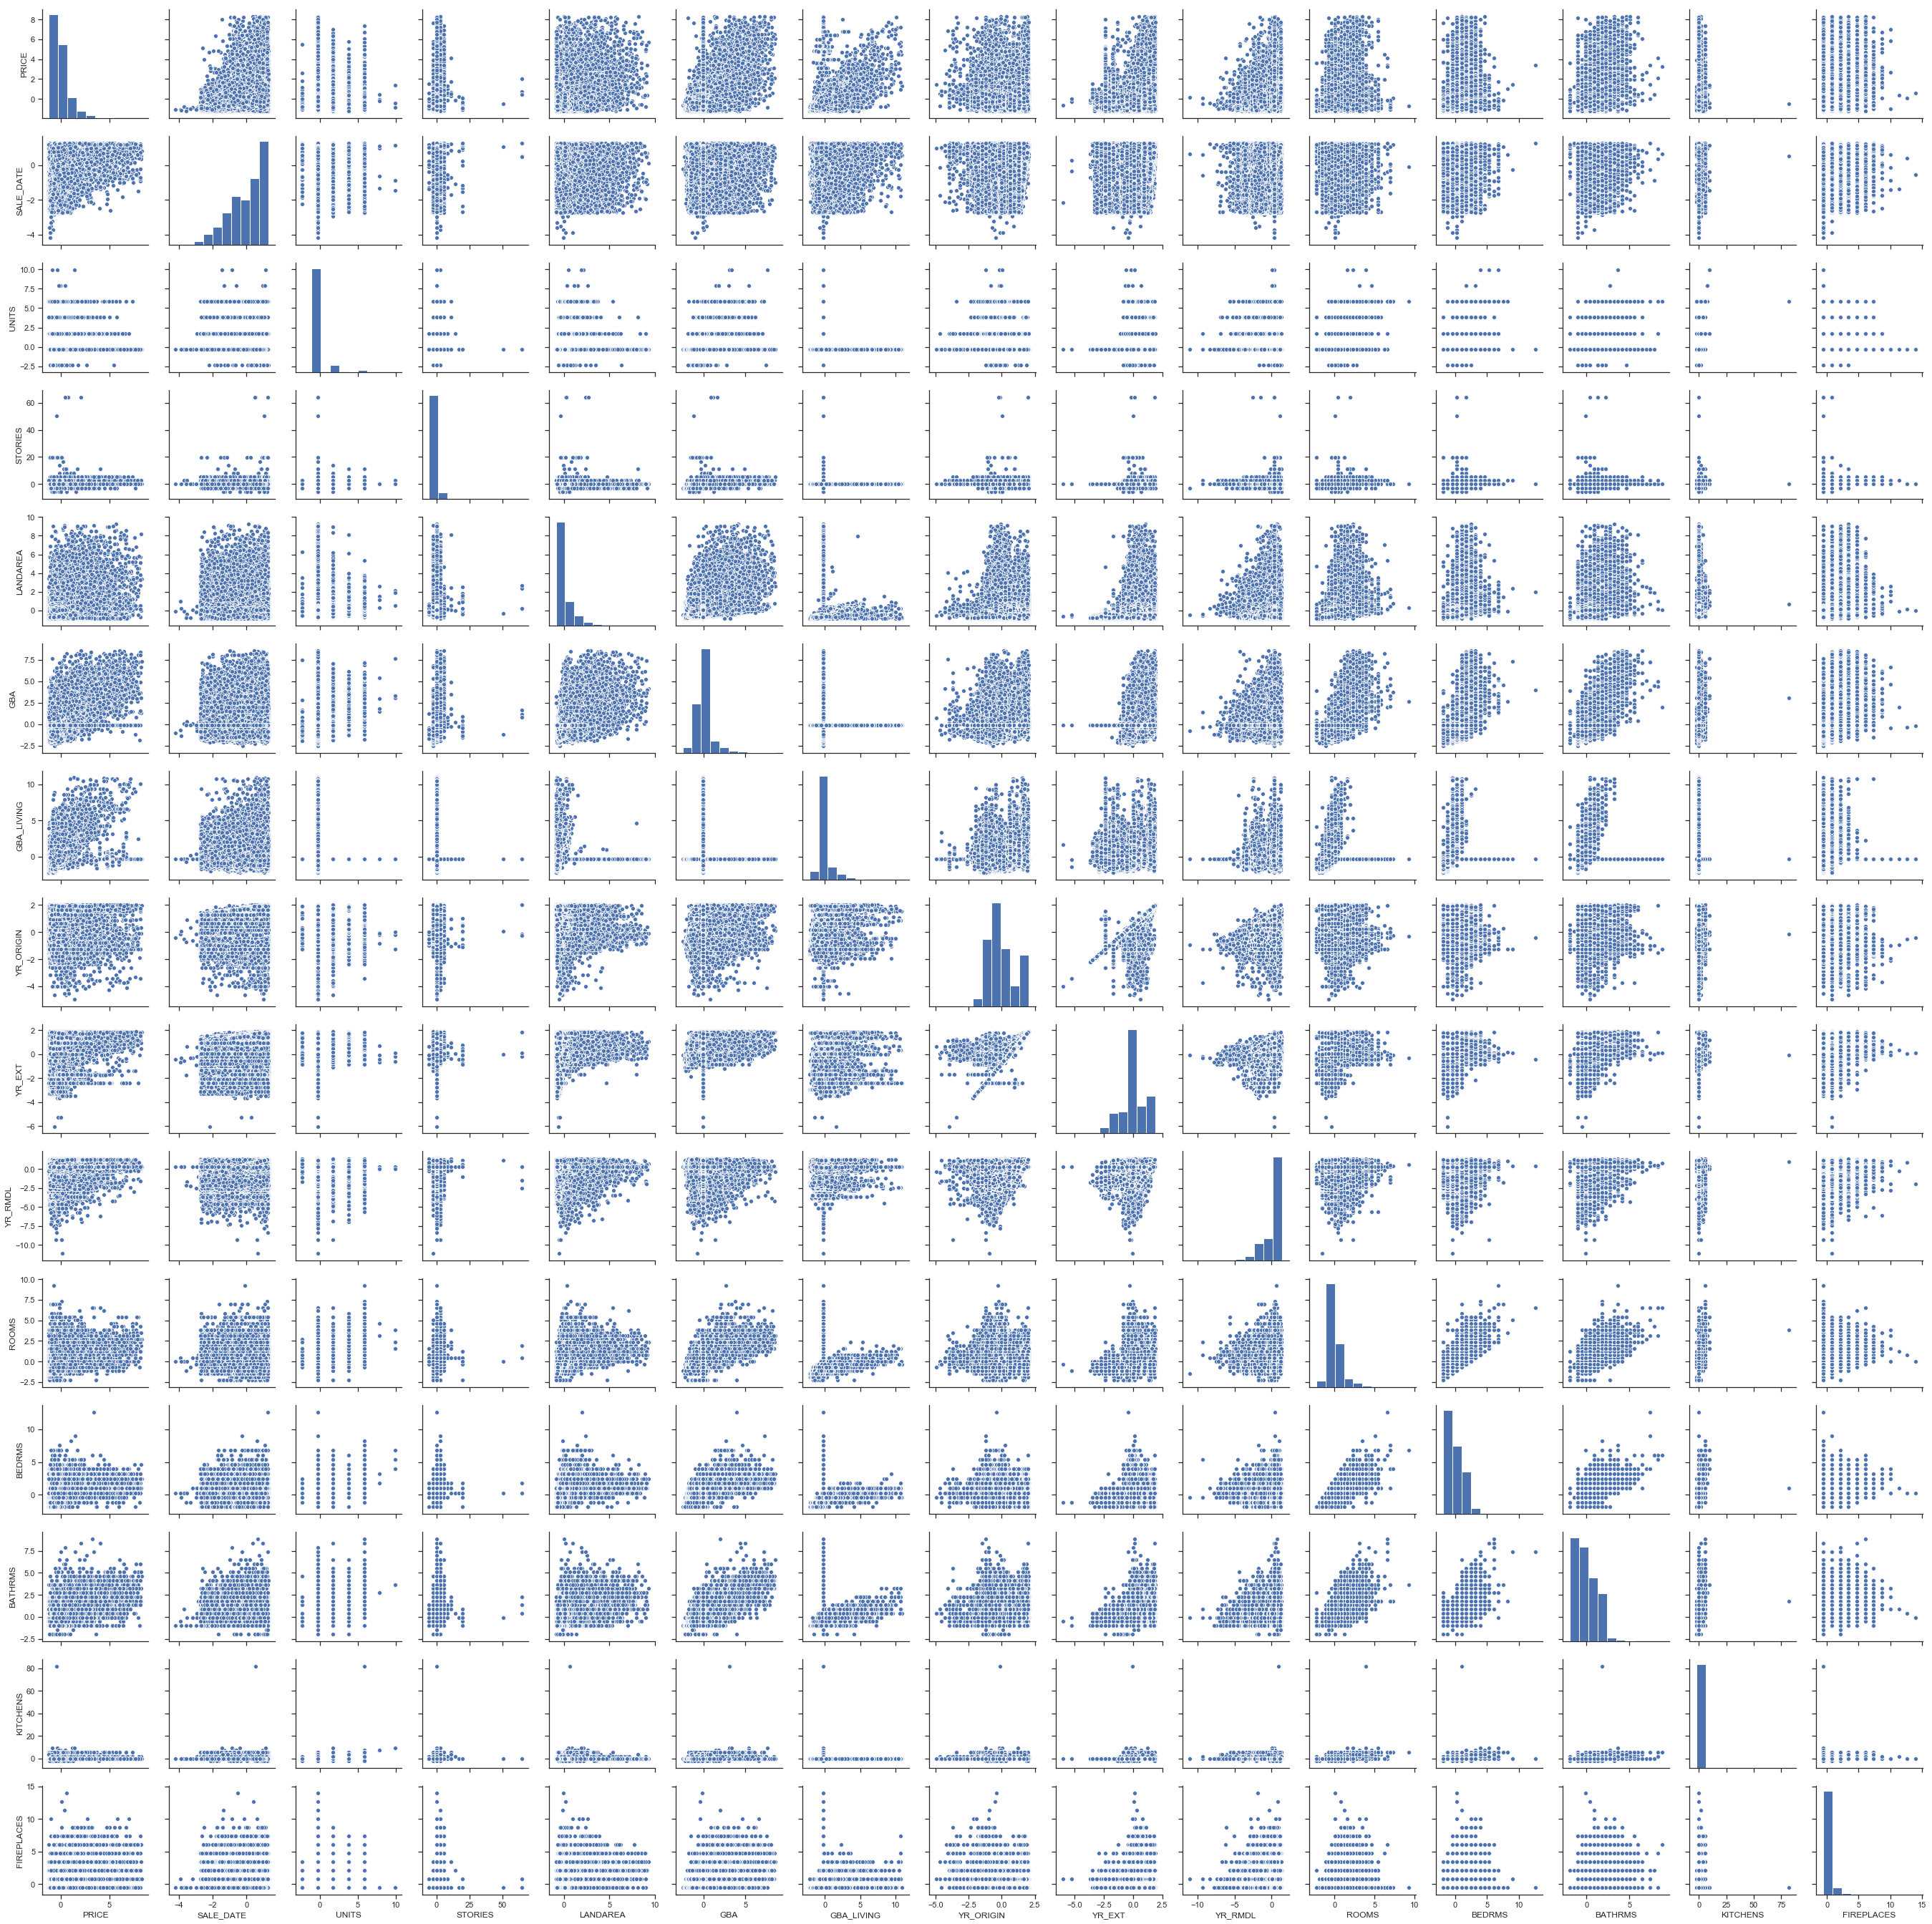

In [ ]:
# scatterplots of numerical columns
num_list = list(dropdf.loc[:, (dropdf.dtypes == np.float64)].columns)
scaledf = pd.DataFrame()
for col in dropdf[num_list]:
    scaledf[col] = (dropdf[col] - np.mean(dropdf[col])) / np.std(dropdf[col])
        
sns.set(style="ticks")
sns.pairplot(scaledf)

#### Potential variables to drop
* kitchen and units .917
* bedrooms and room .845
* bathrooms and bedrooms .735
* bathrooms and rooms .729
* yr_origin and yr_ext .687
* bathrooms and GBA .577
* bedrooms and landarea .570
* rooms and landarea .561
* units and room .515
* kitchens and room .514

In [ ]:
# CENSUS_BLOCK and SQUARE are the most specific geographical facets. 

geo_facets = ['QUADRANT', 'WARD', 'NBHD', 'SUBNBHD', 'CENSUS_BLOCK', 'ZIPCODE', 'SQUARE']
for facet in geo_facets:
    print("The number of unique values in %s IS %f" % (facet, len(finaldf[facet].unique())))

The number of unique values in QUADRANT IS 4.000000
The number of unique values in WARD IS 8.000000
The number of unique values in NBHD IS 56.000000
The number of unique values in SUBNBHD IS 122.000000
The number of unique values in CENSUS_BLOCK IS 3763.000000
The number of unique values in ZIPCODE IS 24.000000
The number of unique values in SQUARE IS 3231.000000


In [ ]:
# subnbhd shows the following:
* comprehensibility
* specificity 

## SCALING FOR REGRESSION:

In [20]:
#scale numerical X variables
num_list = list(dropdf.loc[:, (dropdf.dtypes == np.float64)].columns)
num_list.remove('PRICE')

X_cols = dropdf.drop('PRICE', axis=1)

X_scaled = X_cols.copy()
scaler = StandardScaler()
X_scaled[num_list] = scaler.fit_transform(X_cols[num_list])

# create dummy variables as needed
Xdum = pd.get_dummies(X_scaled, drop_first=True)

# dataframe for regression: regdf
regdf = Xdum.copy()
regdf['PRICE'] = dropdf['PRICE']

regdf

SALE_DATE     UNITS   STORIES  LANDAREA       GBA  GBA_LIVING  \
0      -0.940646  1.766021  2.687261 -0.151590  1.470107   -0.281560   
1       0.959310  1.766021  2.687261 -0.151590  1.470107   -0.281560   
2      -0.543458  1.766021  2.687261 -0.151590  1.404038   -0.281560   
3       0.004790 -0.266387  5.494434  0.074960  6.376567   -0.281560   
4       0.244750  1.766021  2.687261 -0.174859  1.259731   -0.281560   
5       1.241082  1.766021 -0.119912 -0.263986 -0.327654   -0.281560   
6       0.245167  1.766021 -0.119912 -0.092318  1.765677   -0.281560   
7       0.108627 -0.266387 -0.119912 -0.263986 -0.025129   -0.281560   
8      -1.294428  1.766021 -0.119912 -0.263986 -0.136403   -0.281560   
9       0.892712 -0.266387  2.687261  0.028421  3.109651   -0.281560   
10     -0.619572 -0.266387 -0.119912  0.028421  0.197418   -0.281560   
11      0.380050 -0.266387 -0.119912  0.028421 -0.132925   -0.281560   
12      0.368877 -0.266387 -0.119912  0.028421  0.489510   -0.281560   
13     -2.096270 -0.266387 -0.119912  0.028421  0.734659   -0.281560   
14     -0.734610  5.830838  2.687261 -0.075634  1.466630   -0.281560   
15      0.577432  1.766021  2.687261 -0.075634  1.466630   -0.281560   
16     -1.644446 -0.266387  2.687261 -0.075634  1.550085   -0.281560   
17     -1.862100  1.766021  2.687261 -0.075634  1.466630   -0.281560   
18     -0.524011  1.766021  2.687261 -0.075634  1.438811   -0.281560   
19      0.994480  1.766021  2.687261 -0.075634  1.522266   -0.281560   
20      0.843875  1.766021  2.687261 -0.075634  1.466630   -0.281560   
21      1.227012  1.766021  2.687261 -0.075634  1.226696   -0.281560   
22      1.089232  1.766021  2.687261 -0.075634  1.466630   -0.281560   
23     -1.249724  1.766021  2.687261 -0.075634  1.466630   -0.281560   
24      0.164067  1.766021  2.687261 -0.023826  1.623108   -0.281560   
25     -1.541835  1.766021  2.687261 -0.075634  1.779586   -0.281560   
26     -0.054808  1.766021  2.687261 -0.075634  1.779586   -0.281560   
27     -0.532286  1.766021 -0.119912 -0.075634 -0.362427   -0.281560   
28     -1.872032  1.766021  2.687261 -0.075634  0.903308   -0.281560   
29     -0.778869  1.766021 -0.119912 -0.075634 -0.411109   -0.281560   
30      0.056907  1.766021 -0.119912 -0.724989 -0.995294   -0.281560   
31     -1.505014  1.766021 -0.119912 -0.688986 -0.995294   -0.281560   
32     -1.128097  1.766021 -0.119912 -0.286817 -0.499780   -0.281560   
33      0.612185  3.798430  5.494434 -0.472096  2.582841   -0.281560   
34     -2.163319  3.798430 -0.119912 -0.299110  0.896353   -0.281560   
35      0.410253  3.798430  2.687261 -0.175298  1.868257   -0.281560   
36      0.387085  1.766021  2.687261 -0.274523  0.903308   -0.281560   
37     -1.667203  3.798430  2.687261 -0.274523  0.767694   -0.281560   
38     -0.762319  1.766021  2.687261 -0.274523  0.825069   -0.281560   
39     -0.439190  1.766021 -0.119912 -0.541905 -1.377796   -0.281560   
40      0.701952 -0.266387 -0.119912 -0.531807 -0.918794   -0.281560   
41     -0.106115 -0.266387 -0.119912 -0.521269 -0.790134   -0.281560   
42     -0.683307  1.766021 -0.119912 -0.346528 -0.515428   -0.281560   
43     -2.157094  1.766021 -0.119912 -0.368919 -0.515428   -0.281560   
44      0.560034  1.766021 -0.119912 -0.369797 -0.515428   -0.281560   
45      1.136814  1.766021 -0.119912 -0.309647 -0.515428   -0.281560   
46      0.106141  1.766021 -0.119912 -0.288573 -0.515428   -0.281560   
47     -0.719305  1.766021 -0.119912 -0.101099 -0.463268   -0.281560   
48      0.091660  3.798430  2.687261 -0.142809  1.723949   -0.281560   
49     -0.743700 -0.266387 -0.119912 -0.142809 -0.511950   -0.281560   
50      1.168277  5.830838  2.687261 -0.116466  3.313072   -0.281560   
51      0.874921  1.766021  2.687261 -0.025143  2.162088   -0.281560   
52     -2.197660 -0.266387 -0.119912 -0.422922 -0.042516   -0.281560   
53      0.681264 -0.266387 -0.119912 -0.450143 -0.080766   -0.281560   
54     -1.082152  5.830838  5.494434 -0.467705 

In [19]:
print("The size of our frame without dummies is {}".format(finaldf.shape))
print("The size of our regression df is {}".format(regdf.shape))

The size of our frame without dummies is (97223, 37)
The size of our regression df is (97223, 7346)


## FULL MODEL REGRESSION AND OUTLIER REMOVAL WITH STATSMODELS:

In [43]:
# regression function with sklearn using train/test:

X = regdf.drop('PRICE', axis=1).values
y = regdf['PRICE'].values

def linreg(X, y): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=30)
    
    reg_all=LinearRegression()
    reg_all.fit(X_train, y_train)
    
    y_train_pred = reg_all.predict(X_train)
    print('R^2 for training: %.2f' % r2_score(y_train, y_train_pred))
    
    y_test_pred = reg_all.predict(X_test)
    print('R^2 for testing: %.2f' % r2_score(y_test, y_test_pred))
    
    print("Root mean squared error: %.2f"
      % (np.sqrt(mean_squared_error(y_test, y_test_pred))))
        
linreg(X, y)

R^2 for training: 0.83
R^2 for testing: -43036491510337312.00
Root mean squared error: 85179159058673.61


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=30)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

In [ ]:
# regression using statsmodels
y = regdf['PRICE']
X = regdf.drop('PRICE', axis=1)

X = sm.add_constant(X)
model_fit = sm.OLS(y, X).fit()
model_fit.summary()

In [ ]:
# CALCULATIONS REQUIRED FOR PLOTS: https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034

# fitted values (need a constant term for intercept)
model_fitted_y = model_fit.fittedvalues

# model residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

In [ ]:
# Graph styles:
from statsmodels.graphics.gofplots import ProbPlot

plt.style.use('seaborn') # pretty matplotlib plots

plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [ ]:
# Residuals versus Fitted, test for linear data
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'mpg', data=auto, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:3]

for i in abs_resid_top_3.index:
    plot_lm_1.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_residuals[i]));

In [ ]:
# Normal Q-Q Plot, test for normal distribution of residuals

QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

In [ ]:
# Scale - Location, test for homoskedacity, equal spread of residual variance
plot_lm_3 = plt.figure(3)
plot_lm_3.set_figheight(8)
plot_lm_3.set_figwidth(12)

plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_norm_residuals_abs_sqrt[i]));

In [ ]:
# Leverage Plot - find influential points on linear model 
import statsmodels.graphics.regressionplots as plots

fig = plots.influence_plot(model_fit, alpha=0.01, plot_alpha=0.2, fontsize="small")

In [ ]:
# Leverage Plot alternative
plot_lm_4 = plt.figure(4)
plot_lm_4.set_figheight(8)
plot_lm_4.set_figwidth(12)

plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_4.axes[0].set_xlim(0, 0.20)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, 
                               xy=(model_leverage[i], 
                                   model_norm_residuals[i]))
    
# shenanigans for cook's distance contours
def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

p = len(model_fit.params) # number of model parameters

graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance') # 0.5 line
graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50)) # 1 line
plt.legend(loc='upper right');

In [ ]:
#Remove outliers and high leverage points from dataframe:

# Pick leverage cutoff for outliers by approximation (.05)
high_leverage_points = np.where(reg_all.get_influence().hat_matrix_diag > 0.05)

# Based on the histogram of the studentized residuals, remove outside of normal dist 3 SD away from mean....
# or approximate (above 3 in this case)
high_studentized_resid = np.where(reg_all.get_influence().resid_studentized_external > 3)

remove = np.concatenate([high_leverage_points[0], high_studentized_resid[0]])

regdf_no_outiers = regdf.drop(remove)
print regdf.shape, regdf_no_outiers.shape

## FEATURE SELECTION:

#### Potential variables to drop (remove one from each set, compare, leave out. Then progress to the next pair): 
* ##### kitchens, units, bedrooms, room, bathrooms, bedrooms, yr_origin, yr_ext, GBA, landarea,  

* kitchen and units .917
* bedrooms and room .845
* bathrooms and bedrooms .735
* bathrooms and rooms .729
* yr_origin and yr_ext .687
* bathrooms and GBA .577
* bedrooms and landarea .570
* rooms and landarea .561
* units and room .515
* kitchens and room .514

In [ ]:
# linear regressions, removing variables in order until RMSE is optimized

X = regdf_no_outiers.drop('PRICE', axis=1).values
y = regdf_no_outiers['PRICE'].values

def linreg(X, y, vars_dropped): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    reg_all=LinearRegression()
    reg_all.fit(X_train, y_train)
    y_pred = reg_all.predict(X_test)
    print("Train R^2: {}".format(reg_all.score(X_train, y_train)))
    print("Test R^2 for " vars_dropped " : {}".format(reg_all.score(X_test, y_test)))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("Test Root Mean Squared Error for " vars_dropped ": {}".format(rmse))
    
linreg(X, y)

## OUTLIER REMOVAL REMOVAL FROM DF WITHOUT COLINEAR FEATURES:

In [ ]:
# regression function with sklearn using train/test:

# dataframe with best features
feat_df = regdf_no_outliers.drop(   , axis=1)
X = feat_df.drop('PRICE', axis=1).values
y = feat_df['PRICE'].values

def linreg(X, y): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    reg_all=LinearRegression()
    reg_all.fit(X_train, y_train)
    y_pred = reg_all.predict(X_test)
    print("Test R^2: {}".format(reg_all.score(X_test, y_test)))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("Test Root Mean Squared Error: {}".format(rmse))
    
linreg(X, y)

In [ ]:
# regression using statsmodels
import statsmodels.api as sm

y = feat_df['PRICE']
X = feat_df.drop('PRICE', axis=1)

X = sm.add_constant(X)
reg_all = sm.OLS(y, X).fit()
reg_all.summary()

In [ ]:
# leverage plot

import statsmodels.graphics.regressionplots as plots

fig = plots.influence_plot(reg_all, alpha=0.01, plot_alpha=0.2, fontsize="small")

In [ ]:
# residuals plot 

plt.hist(reg_all.get_influence().resid_studentized_external)

In [ ]:
#Remove outliers and high leverage points from dataframe:

# Pick leverage cutoff for outliers by approximation (.05)
high_leverage_points = np.where(reg_all.get_influence().hat_matrix_diag > 0.05)

# Based on the histogram of the studentized residuals, remove outside of normal dist 3 SD away from mean....
# or approximate (above 3 in this case)
high_studentized_resid = np.where(reg_all.get_influence().resid_studentized_external > 3)

remove = np.concatenate([high_leverage_points[0], high_studentized_resid[0]])

feat_no_outliers = feat_df.drop(remove)
print feat_df.shape, feat_no_outliers.shape

## REGULARIZATION WITH SKLEARN FOR FINAL MODEL:

In [ ]:
# ridge regression function
def ridgereg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    space = np.linspace(0, 1, 30)
    param_grid = {'alpha': space}
    
    ridge = Ridge()
    gm_cv = GridSearchCV(ridge, param_grid, cv=5)
    gm_cv.fit(X_train, y_train)

    y_pred = gm_cv.predict(X_test)
    r2 = gm_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Tuned Ridge alpha: {}".format(gm_cv.best_params_))
    print("Tuned Ridge R squared: {}".format(r2))
    print("Tuned Ridge MSE: {}".format(mse))

In [ ]:
# lasso regression function
def lassoreg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    space = np.linspace(0, 1, 30)
    param_grid = {'alpha': space}
    
    lasso = Lasso()
    gm_cv = GridSearchCV(lasso, param_grid, cv=5)
    gm_cv.fit(X_train, y_train)

    y_pred = gm_cv.predict(X_test)
    r2 = gm_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Tuned LASSO Alpha: {}".format(gm_cv.best_params_))
    print("Tuned LASSO R squared: {}".format(r2))
    print("Tuned LASSO MSE: {}".format(mse))

In [ ]:
#ElasticNet function
def elasticnet(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    space = np.linspace(0, 1, 30)
    param_grid = {'l1_ratio': space}
    
    elastic_net = ElasticNet()
    gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)
    gm_cv.fit(X_train, y_train)

    y_pred = gm_cv.predict(X_test)
    r2 = gm_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
    print("Tuned ElasticNet R squared: {}".format(r2))
    print("Tuned ElasticNet MSE: {}".format(mse))

# WHAT SPECIFIC METRICS DESCRIBE OVER FITTING?
* compare training with test set. if model works significantly better on training set (R^2. MSE?), then it's overfitting. 

* "Regularization" process (correcting over fitting):
    * 1. check for outliers
    * 2. remove features
    * 3. try ridge lasso elasticnet
    * 4. go to other methods. 

In [ ]:
#VIF 

%%capture
#gather features
features = "+".join(df.columns - ["annual_inc"])

# get y and X dataframes based on this regression:
y, X = dmatrices('annual_inc ~' + features, df, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif.round(1)



# ***************************


# KFOLD with train test split with logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, 
                                              (dflog.Gender == "Male").values,random_state=5)

clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

# cross validation with train test split logistic regression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average


clf = LogisticRegression()
score = cv_score(clf, Xlr, ylr)
print(score)